#### IF4074 PEMBELAJARAN MESIN LANJUT
Milestone B: Backward Propagation
Convolutional Neural Network

    
Kelompok 6
Rozan Fadhil Al Hafidz 13520039
Adzka Ahmadetya Zaidan 13520127
M Syahrul Surya Putra 13520161

In [ ]:
!pip install prettytable


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
def sigmoid(X):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-X))

def relu(X):
    """ReLU activation function"""
    return np.maximum(0, X)

In [ ]:
class Layer:
    input_shape = None
    output_shape = None
    
    def forward():
        pass

    def backward():
        pass

In [ ]:
import numpy as np
from typing import Literal

class Conv2D(Layer):
    @staticmethod
    def __calculate_output_shape(input_data_shape, kernel_length, padding, strides, n_kernel):
        """
        Calculate output shape of convolution operation
        
        Parameters
        ----------
        input_data_shape : tuple[int, int]
            Shape of input data
        kernel_length : int
            Length of kernel
        padding : int
            Padding to be used for convolution
        strides : int
            Strides to be used for convolution
        """
        return (n_kernel, ((input_data_shape[0] - kernel_length + 2 * padding) // strides[0]) + 1, ((
            input_data_shape[1] - kernel_length + 2 * padding) // strides[1]) + 1)


    def __conv(input_data: np.array, kernel: np.array, padding: int, strides: int, output_shape: tuple[int, int]) -> np.array:
        """Convolution operation on input_data using kernel with padding and strides

            Parameters
            ----------
            input_data : np.array
                Input data to be convolved
            kernel : np.array
                Kernel to be used for convolution
            padding : int
                Padding to be used for convolution
            strides : int
                Strides to be used for convolution
        """

        # Check if input_data is a 2D matrix
        assert kernel.shape[0] == kernel.shape[1], "Kernel must be a square matrix"
        kernel_length = kernel.shape[0]

        # Pad input_data with zeros
        padded_input = np.pad(input_data, padding,
                            mode="constant", constant_values=0)
            
        output = np.zeros(output_shape)

        # Convolve input_data with kernel
        ii = 0
        for i in range(output_shape[0]):
            jj = 0
            for j in range(output_shape[1]):
                output[i, j] = np.sum(
                    padded_input[ii:ii+kernel_length, jj:jj+kernel_length] * kernel)
                jj += strides[0]
            ii += strides[1]
        return output
    
    @staticmethod
    def __activate(X: np.ndarray, activation: Literal["sigmoid", "relu"] = "relu") -> np.ndarray:
        """Activation function to be used on X

            Parameters
            ----------
            X : np.ndarray
                Input data
            activation : str
                Activation function to be used
        """
        if activation == "sigmoid":
            f = lambda x: sigmoid(x)
        elif activation == "relu":
            f = lambda x: relu(x)
        else:
            raise ValueError("Activation function not supported")
        return f(X)


    def __init__(self, input_shape: tuple[int, int, int], padding: int, n_filters: int, filter_size: int, strides: tuple[int, int] = (1, 1)) -> None:
        """Conv2D layer

            Parameters
            ----------
            input_shape : tuple[int, int, int]
                Shape of input data
            padding : int
                Padding to be used for convolution
            n_filters : int
                Number of filters to be used
            filter_size : int
                Size of filters
            strides : tuple[int, int]
                Strides to be used for convolution
        """
        self.n_filters = n_filters
        self.filter_size = filter_size
        
        if (type(strides) == int):
            self.strides = (strides, strides)
        else:
            self.strides = strides  # (stride_height, stride_width)

        self.padding = padding
        self.input_shape = input_shape # (channels, height, width)
        self.output_shape = Conv2D.__calculate_output_shape(
            input_shape[1:], filter_size, padding, strides, n_filters)    # (channels, height, width)
        
        # Initialize weights and biases
        self.bias = np.random.randn(n_filters)
        self.weights = [np.random.randn(filter_size, filter_size) for _ in range(n_filters)]

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass of Conv2D layer

            Parameters
            ----------
            input_data : np.ndarray
                Input data to be convolved
        """
        assert input_data.shape == self.input_shape, "Input data shape must be equal to input shape"
        output = []
        self.input = input_data
        for k in range(self.n_filters):
            res = np.zeros(self.output_shape[1:])
            for datum in input_data:
                res += Conv2D.__conv(datum, self.weights[k], self.padding, self.strides, self.output_shape[1:])
            res += self.bias[k]
            output.append(res)
        return Conv2D.__activate(np.array(output), "relu")

    def backward(self, gradient, learning_rate):
        n_filters, output_height, output_width = gradient.shape

        gradient_input = np.zeros_like(self.input)
        self.gradient_weights = np.zeros_like(self.weights)
        self.gradient_bias = np.sum(gradient, axis=(1, 2))

        if self.padding > 0:
            padded_input = np.pad(self.input, ((0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        else:
            padded_input = self.input

        # FIX FROM HERE
        for i in range(output_height):
            for j in range(output_width):
                input_slice = padded_input[:, i * self.strides[0]:i * self.strides[0] + self.filter_size,
                                        j * self.strides[1]:j * self.strides[1] + self.filter_size]
                for k in range(n_filters):
                    gradient_input[k, i * self.strides[0]:i * self.strides[0] + self.filter_size,
                                    j * self.strides[1]:j * self.strides[1] + self.filter_size] += np.sum(self.weights[k] * gradient[k, i, j])
                    self.gradient_weights[k] += np.sum(input_slice * gradient[k, i, j])

        self.weights -= learning_rate * self.gradient_weights
        self.bias -= learning_rate * self.gradient_bias

        return gradient_input

    def _compile(self, shape):
        return self.output_shape

    def get_params_count(self):
        return self.n_filters * (self.filter_size * self.filter_size + 1)

    # Get Parameters
    def get_params(self):
        params = {
            "input_shape": self.input_shape,
            "padding": self.padding,
            "n_filters": self.n_filters,
            "filter_size": self.filter_size,
            "strides": self.strides,
            "bias": self.bias.tolist(),
            "weights": [w.tolist() for w in self.weights]
        }
        return params

    # Set Parameters
    def set_params(self, params):
        self.input_shape = params["input_shape"]
        self.padding = params["padding"]
        self.n_filters = params["n_filters"]
        self.filter_size = params["filter_size"]
        self.strides = params["strides"]
        self.bias = np.array(params["bias"])
        self.weights = [np.array(w) for w in params["weights"]]

In [ ]:
class Pooling2D(Layer):
    def __init__(self, pool_size: tuple[int, int], strides: tuple[int, int] = None, pool_type: Literal["max", "average"] = "max") -> None:
        """Pooling2D layer

            Parameters
            ----------
            pool_size : tuple[int, int]
                Size of pooling window
            strides : tuple[int, int]
                Strides to be used for pooling
            pool_type: Literal["max", "average"]
                Type of pooling to be used
        """

        if strides is None:
            strides = pool_size

        self.pool_size = pool_size
        self.strides = strides
        self.pool_type = pool_type

    def _compile(self, shape):
        assert len(shape) == 3, "Shape must be 3D matrix (channel, height, width)"
        self.output_shape = (shape[0]), *(((shape[1] - self.pool_size[0]) // self.strides[0]) + 1, (
            (shape[2] - self.pool_size[1]) // self.strides[1]) + 1)
        return self.output_shape

    def __pool(self, input_data: np.ndarray) -> np.ndarray:
        """Pooling operation on input_data

            Parameters
            ----------
            input_data : np.ndarray
                Input data to be pooled
        """
        # Check if input_data is a 2D matrix
        assert len(input_data.shape) == 2, "Input data must be a 2D matrix"

        output = []

        # Pool input_data
        ii = 0

        self.output_shape = (((input_data.shape[0] - self.pool_size[0]) // self.strides[0]) + 1, (
            (input_data.shape[1] - self.pool_size[1]) // self.strides[1]) + 1)

        for _ in range(self.output_shape[0]):
            jj = 0
            output_row = []
            for _ in range(self.output_shape[1]):
                if self.pool_type == "max":
                    output_row.append(np.max(
                        input_data[ii:ii+self.pool_size[0], jj:jj+self.pool_size[1]]))
                elif self.pool_type == "average":
                    output_row.append(np.mean(
                        input_data[ii:ii+self.pool_size[0], jj:jj+self.pool_size[1]]))
                jj += self.strides[0]
            output.append(output_row)
            ii += self.strides[1]
        return np.array(output)

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass of Pooling2D layer

            Parameters
            ----------
            input_data : np.ndarray
                Input data to be pooled
        """
        if len(input_data.shape) == 2:
            input_data = input_data.reshape(1, *input_data.shape)

        assert len(input_data.shape) == 3, "Input data must be a 3D matrix"
        self.input = input_data
        output = []

        for datum in input_data:
            output.append(self.__pool(datum))
        self.output = np.array(output)
        return self.output

    def backward(self, gradient, learning_rate):
        n = self.pool_size[0] * self.pool_size[1]
        for l in range(self.input.shape[0]):
            backward_input = np.zeros(self.input.shape)
            ii = 0
            for i in range(self.output.shape[1]):
                jj = 0
                for j in range(self.output.shape[2]):
                    if self.pool_type == "max":
                         for iii in range(ii, ii+self.pool_size[0]):
                            for jjj in range(jj, jj+self.pool_size[1]):
                                if self.input[l, iii, jjj] == self.output[l, i, j]:
                                    backward_input[l, i, j] = gradient[l, i, j]
                    elif self.pool_type == "average":
                        for iii in range(ii, ii+self.pool_size[0]):
                            for jjj in range(jj, jj+self.pool_size[1]):
                                self.input[l, iii, jjj] = gradient[l, i, j] / n
                    jj += self.strides[0]
                ii += self.strides[1]
        return backward_input

    def get_params(self):
        params = {
            "pool_size": self.pool_size,
            "strides": self.strides,
            "pool_type": self.pool_type
        }
        return params

    def set_params(self, params):
        self.pool_size = params["pool_size"]
        self.strides = params["strides"]
        self.pool_type = params["pool_type"]

In [ ]:
class Dense(Layer):
    def __init__(self, units: int, activation: Literal["sigmoid", "relu"] = "relu") -> None:
        """
        Dense layer

        Parameters
        ----------
        units : int
            Number of neuron
        activation : str
            Activation function ("sigmoid" or "relu")
        """
        self.units = units
        self.activation = activation

        self.output_shape = units

    def _compile(self, shape):
        # Initialize weight & bias
        self.input_size = shape
        self.weights = np.random.randn(shape, self.units)
        self.bias = np.random.randn(self.units)
        
        return self.output_shape

    @staticmethod
    def __activate(X: np.ndarray, activation: Literal["sigmoid", "relu"] = "relu") -> np.ndarray:
        """Activation function

        Parameters
        ----------
        X : np.ndarray
            Input data
        activation : str
            Activation function to be used
        """
        if activation == "sigmoid":
            f = lambda x: sigmoid(x)
        elif activation == "relu":
            f = lambda x: relu(x)
        else:
            raise ValueError("Activation function not supported")
        return f(X)

    def _activate_derivate(self, x):
        if self.activation == "sigmoid":
            return x * (1 - x)
        elif self.activation == "relu":
            return np.array((x > 0)).astype(int)
        else:
            raise ValueError("Activation function not supported")

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass of Dense layer

        Parameters
        ----------
        input_data : np.ndarray
            Input data to be passed through the layer
        """
        
        # Linear transformation (dot product input x weights)
        self.input_data = input_data
        self.output = np.dot(input_data, self.weights) + self.bias
        
        # Activation function
        output = Dense.__activate(self.output, self.activation)
        
        return output

    def backward(self, dL_dy, learning_rate):
        dL_dz = self._activate_derivate(self.output) * dL_dy
        dL_dz = dL_dz.reshape(-1)
        dL_dw = np.dot(self.output, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        dL_dx = np.dot(dL_dz, self.weights.T)

        self.weights -= learning_rate * dL_dw
        self.bias -= learning_rate * dL_db
        
        return dL_dx

    def get_params_count(self):
        return self.input_size * self.units + self.units

    def get_params(self):
        params = {
            "units": self.units,
            "activation": self.activation,
            "weights": self.weights.tolist(),
            "bias": self.bias.tolist()
        }
        return params

    def set_params(self, params):
        self.units = params["units"]
        self.activation = params["activation"]
        self.weights = np.array(params["weights"])
        self.bias = np.array(params["bias"])

In [ ]:
import numpy as np

class Flatten(Layer):
    def __init__(self, data_format=None):
        """
        Flatten layer

        Parameters
        ----------
        data_format : str, optional
            A string, one of 'channels_last' or 'channels_first', specifying the ordering of dimensions.
        """
        super(Flatten, self).__init__()
        self.data_format = data_format

    def _compile(self, shape):
        self.output_shape = (np.prod(shape))
        return self.output_shape

    def forward(self, input_data: np.ndarray) -> np.ndarray:
        """Forward pass of Flatten layer

        Parameters
        ----------
        input_data : np.ndarray
            Input data to be flattened

        Returns
        -------
        np.ndarray
            Flattened input data
        """

        self.input_shape = input_data.shape
        
        return input_data.flatten()

    def backward(self, backward_output, learning_rate):
        return backward_output.reshape(self.input_shape)

    def get_params(self):
        params = {
            "data_format": self.data_format
        }
        return params

    def set_params(self, params):
        self.data_format = params["data_format"]

In [ ]:
from prettytable import PrettyTable

class Sequential:
    def __init__(self, layers: list[object] = []):
        self.layers = layers

    def add(self, layer: Layer) -> None:
        self.layers.append(layer)

    def forward(self, inp: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            inp = layer.forward(inp)
        return inp

    def predict(self, img: np.ndarray) -> np.ndarray:
        return self.forward(img)

    def backward(self, dL_dx, learning_rate):
        for layer in reversed(self.layers):
            dL_dx = layer.backward(dL_dx, learning_rate)
        return dL_dx

    def compile(self):
        assert len(self.layers) > 0, "Tambah layer terlebih dahulu"

        input_shape = self.layers[0].input_shape
        for layer in self.layers:
            layer._compile(input_shape)
            input_shape = layer.output_shape

    def summary(self):
        total_params = 0
        print("Model Summary:")

        table = PrettyTable(["Nama Layer", "Output Shape", "Parameter"])
        for i, layer in enumerate(self.layers):
            layer_name = layer.__class__.__name__
            output_shape = layer.output_shape if hasattr(layer, "output_shape") else None
            params = layer.get_params_count() if hasattr(layer, "get_params_count") else 0
            total_params += params
            
            table.add_row([layer_name, output_shape, params])

        print(table)
        print(f"Total Parameters: {total_params}")

    def fit(self, training_data, epochs: int, learning_rate: float) -> None:
        batch_size = len(train_data[0][0])
        for epoch in range(epochs):
            total_loss = 0
            n_batch = 0
            for i in range(batch_size):
                X_batch = training_data[epoch][0][i]
                y_batch = training_data[epoch][1][i].reshape(-1)
                y_batch[np.isneginf(y_batch)] = 0
                y_batch[np.isinf(y_batch)] = 0
                
                output = self.forward(X_batch)
                output = output.reshape(-1)

                # mean squared error
                loss = np.sum((output - y_batch)**2) / batch_size
                total_loss += loss

                dL_dx = -2 * (output - y_batch)
                self.backward(dL_dx, learning_rate)
                n_batch += 1
            avg_loss = total_loss / n_batch
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    # Save Model
    def save_model(self, filename):
        model_params = []
        for layer in self.layers:
            layer_params = {
                "type": layer.__class__.__name__,
                "params": layer.get_params()
            }
            model_params.append(layer_params)

        with open(filename, 'w') as json_file:
            json.dump(model_params, json_file, indent=4)

    def load_model(self, filename):
        with open(filename, 'r') as json_file:
            model_params = json.load(json_file)

        layers = []
        for layer_params in model_params:
            layer_type = layer_params["type"]
            layer_args = layer_params["params"]
            
            if layer_type == "Conv2D":
                layer = Conv2D(input_shape=layer_args["input_shape"],
                                padding=layer_args["padding"],
                                n_filters=layer_args["n_filters"],
                                filter_size=layer_args["filter_size"],
                                strides=layer_args["strides"])
                layer.bias = np.array(layer_args["bias"])
                layer.weights = [np.array(w) for w in layer_args["weights"]]
            elif layer_type == "Dense":
                layer = Dense(units=layer_args["units"],
                              activation=layer_args["activation"])
                layer.bias = np.array(layer_args["bias"])
                layer.weights = np.array(layer_args["weights"])
            elif layer_type == "Pooling2D":
                layer = Pooling2D(pool_size=layer_args["pool_size"],
                                  strides=layer_args["strides"],
                                  pool_type=layer_args["pool_type"])
            elif layer_type == "Flatten":
                layer = Flatten(data_format=layer_args["data_format"])
            else:
                raise ValueError(f"Unsupported layer type: {layer_type}")

            layers.append(layer)

        loaded_model = Sequential(layers)
        loaded_model.compile()
        return loaded_model

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

datagen = ImageDataGenerator(rescale=1./255,
                             data_format="channels_first")

train_data = datagen.flow_from_directory(
    'PandasBears/Train',
    batch_size=batch_size,
    class_mode='binary',
    seed=2241
)

test_data = datagen.flow_from_directory(
    'PandasBears/Test',
    class_mode='binary',
    seed=2241
)

Found 500 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [ ]:
model = Sequential([
        Conv2D(n_filters=2, filter_size=5, strides=(3,3), input_shape=train_data[0][0][0].shape, padding=0),
        Pooling2D(pool_size=(2, 2), strides=(3,3), pool_type='max'),
        Flatten(),
        Dense(units=10, activation='relu'),
        Dense(units=1, activation='sigmoid')
    ])
    
model.compile()

In [ ]:
model.save_model('model_parameters.json')

In [ ]:
model.summary()

Model Summary:
+------------+--------------+-----------+
| Nama Layer | Output Shape | Parameter |
+------------+--------------+-----------+
|   Conv2D   | (2, 84, 84)  |     52    |
| Pooling2D  | (2, 28, 28)  |     0     |
|  Flatten   |     1568     |     0     |
|   Dense    |      10      |   15690   |
|   Dense    |      1       |     11    |
+------------+--------------+-----------+
Total Parameters: 15753


In [ ]:
loaded_model = Sequential()
loaded_model = loaded_model.load_model('model_parameters.json')

In [ ]:
loaded_model.summary()

Model Summary:
+------------+--------------+-----------+
| Nama Layer | Output Shape | Parameter |
+------------+--------------+-----------+
|   Conv2D   | (2, 84, 84)  |     52    |
| Pooling2D  | (2, 28, 28)  |     0     |
|  Flatten   |     1568     |     0     |
|   Dense    |      10      |   15690   |
|   Dense    |      1       |     11    |
+------------+--------------+-----------+
Total Parameters: 15753


In [ ]:
model.fit(train_data, 5, 0.001)

Epoch 1/5, Loss: 0.042968749999997946
Epoch 2/5, Loss: 0.0351562498700662
Epoch 3/5, Loss: 0.04296868429308181
Epoch 4/5, Loss: 0.019530922272178307
Epoch 5/5, Loss: 0.031246996648504236


Acc: 0.68


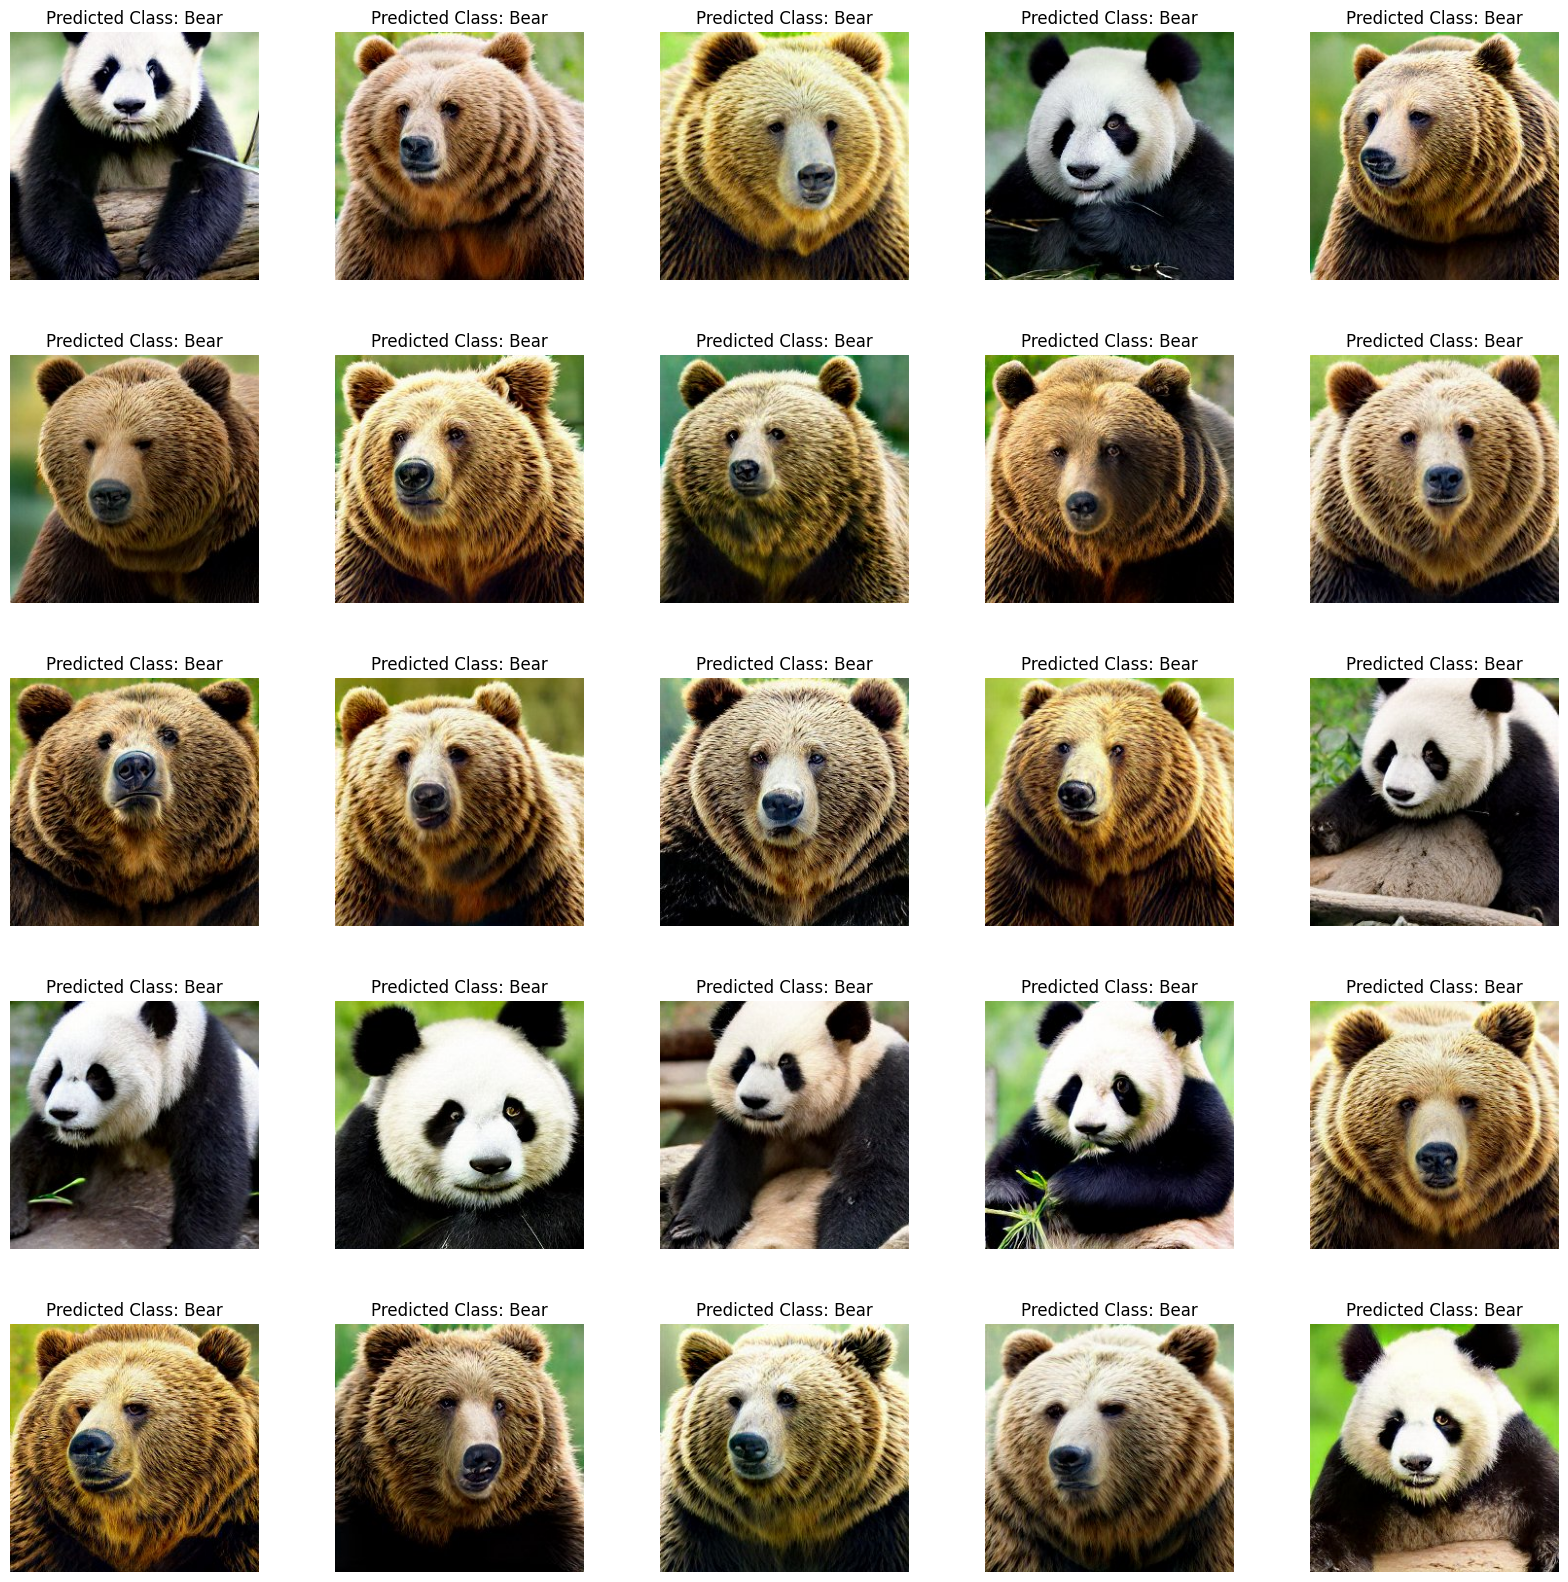

In [ ]:
acc = 0
total = min(len(test_data[0][0]), 25)
label = ["Bear", "Panda"]

plt.figure(figsize = (20,20))
for i in range(total):
    pred = model.predict(test_data[0][0][i])
    if (np.rint(pred) == test_data[0][1][i]):
        acc += 1
    predicted_class = label[0] if pred < 0.5 else label[1]
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(test_data[0][0][i].transpose(1,2,0))
    plt.title(f"Predicted Class: {predicted_class}")
    plt.axis('off')

print(f"Acc: {acc/total}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61bb34cb-2316-475c-9595-96cf5c0e1564' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>